# **📰 해외뉴스 감성지수와 🗣 국내여론 반응지수 제작을 통한 주가방향성 예측**


---
### "*개인투자자들의 수익률 부진 이유 TOP2*"
### "*1위 : 주식시장 흐름에 대한 안목 부족*"
### "*2위 : 기업 상황에 대한 분석 능력 한계*"

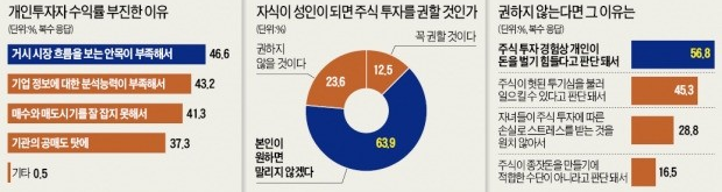

- 현재, 개인투자자들은 해외 주식시장 흐름에 대한 안목 부족, 기업 상황에 대한 분석 능력 한계 등의 이유로 수익 달성에 어려움을 겪고 있음
- 이에 초보투자자들을 대상으로 **접근성**은 좋지만 **산재되어있는** 비정형 데이터(=해외뉴스정보, 국내여론) 속 투자기회를 직관적으로 알려주고자 함
- 주식등락 예측 모델에 흔히 사용되는 재무정보에서 벗어나 **비재무적 정보** 속 긍정/부정 또는 칭찬/비난과 같은 반응지수를 적극 활용한데에 차별성을 가짐.
- 특히, **해외 현지 정보**과 **국내여론**을 동시에 ✊꽉 잡기✊ 위한 피쳐들로 구성함.

# **1. 해외뉴스 감성지수 제작**

## 1-1. **HANDMADE 감성사전 기반** 뉴스 감성분석
나스닥 뉴스 전문 데이터 수집을 위해 url링크로 접속 후 selenium을 이용한 동적 크롤링 실시

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/NH대회 공유문서함

/content/drive/MyDrive/NH대회 공유문서함


In [ ]:
import pandas as pd
import datetime
from glob import glob
import os
import numpy as np
from tqdm import tqdm, tqdm_notebook
import random

In [ ]:
df_rss = pd.read_csv('data_files/open/NASDAQ_RSS_IFO/NASDAQ_RSS_IFO_202308.csv', encoding='cp949') # 나스닥 RSS 피드 데이터 불러오기 - 8월 데이터만 사용
df_rss['rgs_dt'] = pd.to_datetime(df_rss['rgs_dt'].astype('str')) # 날짜 형식으로 변경
df_rss.drop_duplicates(['url_ifo'], keep='first', ignore_index=True, inplace=True) # 중복된 기사가 있으므로 제거

In [ ]:
pd.set_option('display.max.colwidth', 100)
print(df_rss.info())
df_rss.head()

In [ ]:
news_whole = pd.read_csv("data_files/NASDAQ_RSS_IFO_202308_news.csv")['news_whole'] #크롤링한 뉴스 전문 가져오기
df_rss['news_whole'] = news_whole
news_whole[0]

"(RTTNews) - The Indonesia stock market has moved higher in consecutive trading days, gathering more than35 points or 0.5 percent in that span. The Jakarta Composite Index now sits just above the 6,930-point plateau and it's likely to be rangebound again on Tuesday. The global forecast for the Asian markets is cautiously optimistic amidst a lack of major catalysts. The European markets were mixed and little changed and the U.S. bourses saw mild upside, and the Asian markets figure to split the difference. The JCI finished modestly higher on Monday following gains from the cement companies and mixed performances from the financial and resource shares. For the day, the index gained 31.13 points or 0.45 percent to finish at 6,931.36. Among the actives, Bank CIMB Niaga surged 4.97 percent, while Bank Mandiri collected 0.44 percent, Bank Danamon Indonesia plunged 3.16 percent, Bank Rakyat Indonesia sank 0.88 percent, Indosat Ooredoo Hutchison spiked 2.79 percent, Indocement rose 0.24 percen

### 금융 맞춤 감성사전 구축
- 학습 데이터 :  Finance Phrase Bank (Malo et al., 2014) - huggingface 제공
- 금융 뉴스 데이터에서 4,840여개의 문장 추출
- 각 뉴스에 대한 감성라벨링은 16명의 전문지식을 갖춘 연구자들에 의해 수동 라벨링되었음
- 감정 label 종류 : positive, neutral, negative
- 이후 KeyBERT를 활용해 메인 단어와 유사도가 높은 긍/부정 키워드를 Finance Phrase Bank 데이터에서 추출함.
- 참고자료
  - <경제용어 감성사전 구축방안 연구 -  한국은행 발간>
  - https://www.bok.or.kr/portal/cmmn/file/fileDown.do?menuNo=200440&atchFileId=FILE_000000000019796&fileSn=3
- 연관도 점수를 계산하여 연관도 점수가 높은 순으로 정렬하여 사전을 구축함.


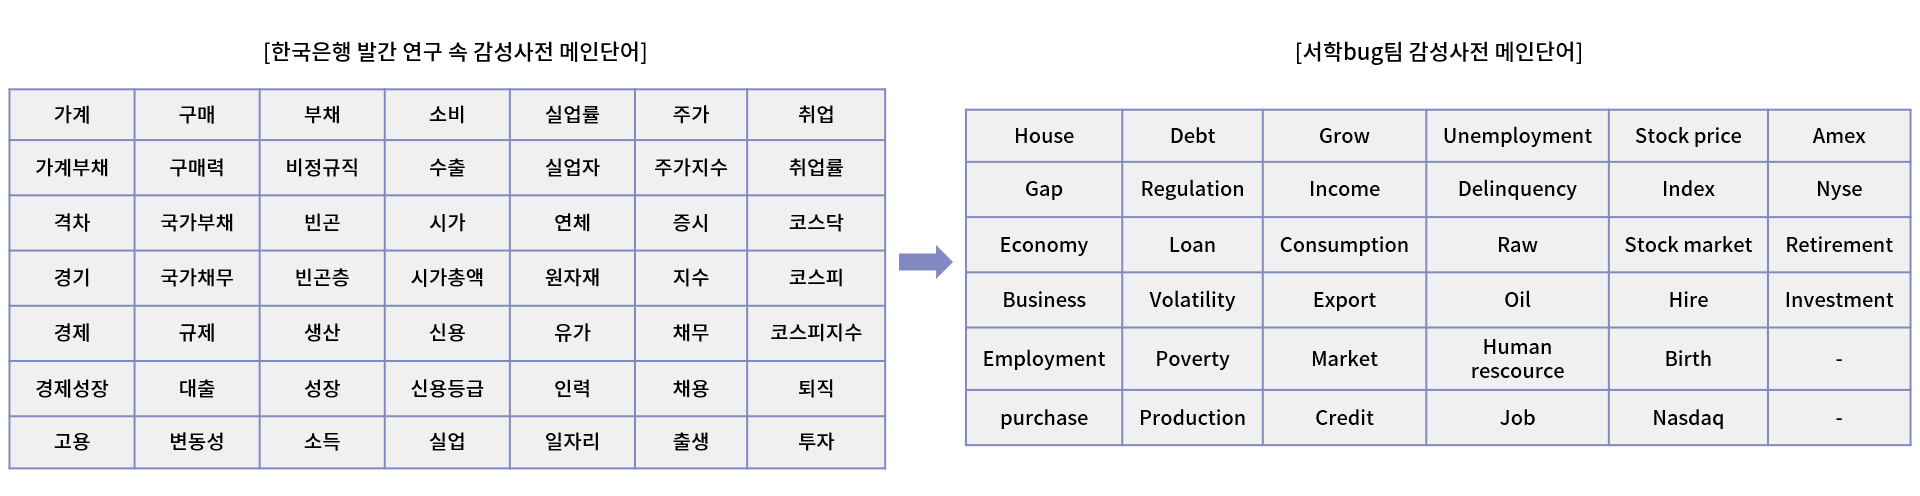

In [ ]:
# Finance Phrase Bank 데이터 불러오기
fin_corpus = pd.read_csv('data_files/huggingface_finance_data.csv')

In [ ]:
# 전처리 메소드 만들기
import re
def clean_text(texts):
  corpus = []
  for i in range(0, len(texts)):

    temp = re.sub(r'[@%\\*=()/~#&\+á?\xc3\xa1\-\|\.\:\;\!\-\,\_\~\$\'\"\n\]\[\>]', '',str(texts[i])) #@%*=()/+ 와 같은 문장부호 제거
    temp = re.sub(r'\d+','', str(temp))#숫자 제거
    temp = temp.lower() #소문자 변환
    temp = re.sub(r'\s+', ' ', str(temp)) #extra space 제거
    temp = re.sub(r'<[^>]+>','',str(temp)) #Html tags 제거
    temp = re.sub(r'\s+', ' ', str(temp)) #spaces 제거
    temp = re.sub(r"^\s+", '', str(temp)) #space from start 제거
    temp = re.sub(r'\s+$', '', str(temp)) #space from the end 제거
    temp = re.sub(r'_', ' ', str(temp)) #space from the end 제거
    corpus.append(temp)

  return corpus

In [ ]:
temp = clean_text(fin_corpus['sentence']) #메소드 적용
fin_corpus['sentence_clean'] = temp
fin_corpus.head()

,labels,sentence,kor_sentence,sentence_clean
0,neutral,"According to Gran, the company has no plans to move all production to Russia, although that is w...","Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로 옮길 계획이 없다고 한다.",according to gran the company has no plans to move all production to russia although that is whe...
1,neutral,"Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to...",테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평방미터 이상의 면적을 단계적으로 개발할 계획이라고 성명은 밝혔다.,technopolis plans to develop in stages an area of no less than square meters in order to host co...
2,negative,The international electronic industry company Elcoteq has laid off tens of employees from its Ta...,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 해고와는 달리 회사는 사무직 직원 수를 줄였다고 일간 포스티메스가 보도했다.",the international electronic industry company elcoteq has laid off tens of employees from its ta...
3,positive,With the new production plant the company would increase its capacity to meet the expected incre...,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가시키고 원자재 사용을 개선하여 생산 수익성을 높일 것이다.,with the new production plant the company would increase its capacity to meet the expected incre...
4,positive,"According to the company's updated strategy for the years 2009-2012, Basware targets a long-term...","2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 40% 범위의 장기적인 순매출 성장을 목표로 하고 있으며, 영업이익률은 순매출액의 10% -...",according to the companys updated strategy for the years basware targets a longterm net sales gr...


In [ ]:
# 불용어 제거
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
nltk.download("punkt")
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stopwords_list = stopwords.words('english')

In [ ]:
# tokenizing
from nltk.tokenize import word_tokenize
temp2 = []

train_clear_text = list(fin_corpus['sentence_clean'])

for i in tqdm(range(len(train_clear_text))):
    temp = word_tokenize(train_clear_text[i])

    temp = [word for word in temp if word not in stopwords_list]
    temp = [word for word in temp if len(word) > 1]

    temp2.append(temp)

fin_corpus['sentence_clean2'] = temp2

100%|██████████| 4846/4846 [00:01<00:00, 2823.46it/s]


In [ ]:
# 품사 원형 lemmatization
# 명사의 경우 보통 복수 -> 단수 형태로 변형 / 동사의 경우 원형 복원
from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None # for easy if-statement

In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
lemmatized_words = []
for tokens in temp2 :
  temp = []
  tagged = nltk.pos_tag(tokens)
  for word, tag in tagged:
    wntag = get_wordnet_pos(tag)
    if wntag is None:# not supply tag in case of None
        lemma = lemmatizer.lemmatize(word)
    else:
        lemma = lemmatizer.lemmatize(word, pos=wntag)
    temp.append(lemma)
  lemmatized_words.append(' '.join(map(str,temp)))

fin_corpus['sentence_clean2'] = lemmatized_words

In [ ]:
fin_corpus[:2]['sentence'][1] # 원본 문장

'Technopolis plans to develop in stages an area of no less than 100,000 square meters in order to host companies working in computer technologies and telecommunications, the statement said.'

In [ ]:
fin_corpus[:2]['sentence_clean2'][1] # 전처리 후 문장

'technopolis plan develop stage area less square meter order host company work computer technology telecommunications statement say'

In [ ]:
# 긍정 문장과 부정 문장을 분류하여 저장
fin_corpus_pos = fin_corpus[fin_corpus['labels'] == 'positive'].reset_index(drop = True) # 1363개
fin_corpus_neg = fin_corpus[fin_corpus['labels'] == 'negative'].reset_index(drop = True) # 604개

### 예를 들어, 주제 단어: 고용(employment)에 대한 감성 사전을 만들고자 한다.
- step1. 주제 단어의 다른 형태 또는 유의어를 주제 단어로 변경
  - 예를 들어 'employment'라는 주제 단어의 다른 품사 형태인 'employee', 'employer' 등도 employment로 변경한다.
- step2. KeyBERT를 활용해 연관긍정단어, 부정단어 추출하여 사전 구축
- step3. 이때 실제로는 연관성이 낮은 단어들은 수작업으로 제거하는 후처리 작업 실시
- step4. 위 3가지 과정을 모든 메인단어마다 실시
- 감성 사전 데이터는 링크에서 다운받을 수 있음


In [ ]:
# 주제 단어의 다른 형태 또는 유의어를 주제 단어로 변경
# 예를 들어 'employment'라는 주제 단어의 다른 품사 형태인 'employee', 'employer' 등도 employment로 변경한다.
def replace_text(texts):
  corpus = []
  for i in range(0, len(texts)):
    temp = re.sub('employee', 'employment', texts[i])
    temp = re.sub('employer', 'employment', temp)
    corpus.append(temp)

  return corpus

fin_corpus_pos['sentence_final'] = replace_text(fin_corpus_pos['sentence_clean2'])
fin_corpus_neg['sentence_final'] = replace_text(fin_corpus_neg['sentence_clean2'])

In [ ]:
pip install keybert

In [ ]:
from keybert import KeyBERT

# 연관 긍정 단어 추출
def POS_BERT(title):

    array_text = pd.DataFrame(fin_corpus_pos[fin_corpus_pos['sentence_final'].str.contains(title)]['sentence_final']).to_numpy()

    bow = []
    from keybert import KeyBERT
    kw_extractor = KeyBERT('distilbert-base-nli-mean-tokens')
    for j in range(len(array_text)):
        keywords = kw_extractor.extract_keywords(array_text[j][0])
        bow.append(keywords)

    new_bow = []
    for i in range(0, len(bow)):
        for j in range(len(bow[i])):
            new_bow.append(bow[i][j])

    keyword = pd.DataFrame(new_bow, columns=['keyword', 'weight'])
    return keyword.groupby('keyword').agg('sum').sort_values('weight', ascending=False).head(20)

pos_dictionary = POS_BERT('employment')[1:20].reset_index()
pos_dictionary['main'] = 'employment'
pos_dictionary = pos_dictionary[['main', 'keyword', 'weight']]
pos_dictionary

In [ ]:
pos_dictionary

,main,keyword,weight
0,employment,enthusiasm,0.6825
1,employment,competition,0.6086
2,employment,great,0.5523
3,employment,customer,0.5383
4,employment,corporate,0.4881
5,employment,shareholder,0.4797
6,employment,value,0.4552
7,employment,madison,0.4347
8,employment,receive,0.4271
9,employment,good,0.4263


In [ ]:
# 연관 부정 단어 추출
def NEG_BERT(title):

    array_text = pd.DataFrame(fin_corpus_neg[fin_corpus_neg['sentence_final'].str.contains(title)]['sentence_final']).to_numpy()

    bow = []
    from keybert import KeyBERT
    kw_extractor = KeyBERT('distilbert-base-nli-mean-tokens')
    for j in range(len(array_text)):
        keywords = kw_extractor.extract_keywords(array_text[j][0])
        bow.append(keywords)

    new_bow = []
    for i in range(0, len(bow)):
        for j in range(len(bow[i])):
            new_bow.append(bow[i][j])

    keyword = pd.DataFrame(new_bow, columns=['keyword', 'weight'])
    return keyword.groupby('keyword').agg('sum').sort_values('weight', ascending=False).head(20)

neg_dictionary = NEG_BERT('employment')[1:20].reset_index()
neg_dictionary['main'] = 'employment'
neg_dictionary = neg_dictionary[['main', 'keyword', 'weight']]
neg_dictionary

,main,keyword,weight
0,employment,finland,2.8068
1,employment,terminate,1.9718
2,employment,contract,1.9631
3,employment,layoff,1.6647
4,employment,finnish,1.5712
5,employment,company,1.3392
6,employment,negotiation,0.9965
7,employment,salaried,0.8723
8,employment,temporary,0.8337
9,employment,march,0.8300


### 감성사전 기반 스코어링
- 종목별, 일자별, 하나의 나스닥 기사 내에 주제단어-키워드 존재하면 점수부여
- 확률값이 0.5 이상 : positive / 0.5 미만 : negative / 0 : neutral

In [ ]:
temp = clean_text(df_rss['news_whole']) # 전처리 메소드 적용
df_rss['sentence_clean'] = temp

In [ ]:
from nltk.tokenize import word_tokenize
temp2 = []

train_clear_text = list(df_rss['sentence_clean'])

for i in tqdm(range(len(train_clear_text))):
    temp = word_tokenize(train_clear_text[i]) # 기사 tokenizing

    temp = [word for word in temp if word not in stopwords_list] # 불용어 제외
    temp = [word for word in temp if len(word) > 1]

    temp2.append(temp)

df_rss['sentence_clean'] = temp2

100%|██████████| 33053/33053 [02:20<00:00, 235.38it/s]


In [ ]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
lemmatized_words = []
for tokens in tqdm(temp2) :
  temp = []
  tagged = nltk.pos_tag(tokens)
  for word, tag in tagged:
    wntag = get_wordnet_pos(tag)
    if wntag is None:# not supply tag in case of None
        lemma = lemmatizer.lemmatize(word)
    else:
        lemma = lemmatizer.lemmatize(word, pos=wntag)
    temp.append(lemma)
  lemmatized_words.append(' '.join(map(str,temp)))

df_rss['sentence_clean'] = lemmatized_words

100%|██████████| 33053/33053 [14:10<00:00, 38.85it/s]


In [ ]:
# 감성 사전 불러오기
pos_dictionary = pd.read_csv('data_files/pos_dictionary_final.csv')
neg_dictionary = pd.read_csv('data_files/neg_dictionary_final.csv')

In [ ]:
def word_scoring(news_text):
  temp = []
  for news in tqdm(news_text) :
    pos_score, count = 0,0
    for i in range(len(pos_dictionary)) :
      if pos_dictionary['main'][i] in news and pos_dictionary['keyword'][i] in news :
        pos_score += 1
        count += 1
    for i in range(len(neg_dictionary)) :
      if neg_dictionary['main'][i] in news and neg_dictionary['keyword'][i] in news :
        count += 1
    if count == 0 :
      answer = 0
    else :
      answer = pos_score/count
    temp.append(answer)
  return temp

df_rss['dic_prob'] = word_scoring(df_rss['sentence_clean'])

100%|██████████| 33053/33053 [02:34<00:00, 214.37it/s]


In [ ]:
def f1(df_rss):
    if df_rss['dic_prob'] == 0 :
        val = 2 #neutral
    elif df_rss['dic_prob'] < 0.5 :
        val = 1 #negative
    else :
        val = 0 #positive
    return val

df_rss['dic_sentiment']  = df_rss.apply(f1, axis=1)

In [ ]:
# df_rss.to_csv("word_analysis2.csv", index=False)

## 1-2. **FinBERT 기반** 뉴스 감성분석

-  FinBERT는 금융 관련 뉴스 데이터(1-1에서 사용한 Finance Phrase Bank (Malo et al., 2014) 와 동일)를 기반으로 훈련시킨 BERT 모델임.
- FinBERT를 사용한 financial sentiment analysis task의 성능은 높게 인정받고 있는 상황
- 참고 링크 : https://github.com/ProsusAI/finBERT



In [ ]:
# Hugging Space에서 FinBERT model 불러오기
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn

sentences = df_rss['news_smy_ifo']
predictions_probs = []
predictions_labels = []

for sen in tqdm(sentences):
    if len(tokenizer(sen).input_ids) > 512:
        predictions_labels += [-1]
        predictions_probs.append(torch.Tensor([0.0, 0.0, 0.0]))
        continue # token 개수가 512개를 넘는 것은 모델이 처리하지 못하므로 0점 처리
    inputs = tokenizer(sen, return_tensors='pt')
    logits = model(**inputs).logits[0]
    logits = logits.clone().detach().cpu()

    probs = nn.functional.softmax(logits, dim=-1) # 3가지 감성 상태로 분류하기 위한 확률값(score)
    predict_content = logits.argmax(axis=-1).flatten().tolist() # 3가지 감성 상태 중 하나로 분류(classification)

    predictions_labels += predict_content
    predictions_probs.append(probs)

probs_df = torch.cat(predictions_probs, 0).reshape((-1, 3))
probs_df = pd.DataFrame(probs_df)
# label_list=['positive','negative','neutral']
probs_df.columns = ['fin_positive_prob','fin_negative_prob','fin_neutral_prob']


  0%|          | 0/33053 [00:00<?, ?it/s]

100%|██████████| 33053/33053 [1:49:45<00:00,  5.02it/s]  


In [ ]:
print(len(sentences),len(predictions_labels))

33053 33053


In [ ]:
# RSS 피드 데이터프레임에 finbert기반 감성 점수와 분류 결과를 덧붙이기
df_rss = pd.concat([df_rss, probs_df], axis=1)
df_rss['fin_sentiment'] = predictions_labels

In [ ]:
df_rss.head()

,rgs_dt,tck_iem_cd,til_ifo,ctgy_cfc_ifo,mdi_ifo,news_smy_ifo,rld_ose_iem_tck_cd,url_ifo,news_whole,sentence_clean,dic_prob,dic_sentiment,fin_positive_prob,fin_negative_prob,fin_neutral_prob,fin_sentiment
0,2023-08-01,Latest,Steady Start Seen For Indonesia Stock Market,Markets,RTTNews,"(RTTNews) - The Indonesia stock market has moved higher in consecutive trading days, gathering m...",_,https://www.nasdaq.com/articles/steady-start-seen-for-indonesia-stock-market-0,"(RTTNews) - The Indonesia stock market has moved higher in consecutive trading days, gathering m...",rttnews indonesia stock market move higher consecutive trading day gather point percent span jak...,0.400000,1,0.939774,0.022632,0.037594,0
1,2023-08-01,ARES,Ares Management (ARES) Q2 Earnings: Taking a Look at Key Metrics Versus Estimates,Technology,Zacks,"For the quarter ended June 2023, Ares Management (ARES) reported revenue of $792.1 million, up 2...",ARES,https://www.nasdaq.com/articles/ares-management-ares-q2-earnings:-taking-a-look-at-key-metrics-v...,"For the quarter ended June 2023, Ares Management (ARES) reported revenue of $792.1 million, up 2...",quarter end june are management are report revenue million period last year eps come compare yea...,0.692308,0,0.947465,0.034008,0.018527,0
2,2023-08-01,EW,RBC Capital Reiterates Edwards Lifesciences (EW) Outperform Recommendation,Stocks,Fintel,"Fintel reports that on August 1, 2023, RBC Capital reiterated coverage of Edwards Lifesciences (...",EW,https://www.nasdaq.com/articles/rbc-capital-reiterates-edwards-lifesciences-ew-outperform-recomm...,"Fintel reports that on August 1, 2023, RBC Capital reiterated coverage of Edwards Lifesciences (...",fintel report august rbc capital reiterate coverage edward lifesciences nyseew outperform recomm...,0.631579,0,0.948758,0.018359,0.032883,0
3,2023-08-01,LMAT,"Noteworthy Tuesday Option Activity: LMAT, MSTR, TPC","Markets,Stocks,Options",BNK Invest,"Looking at options trading activity among components of the Russell 3000 index, there is notewor...","LMAT,LMAT,MSTR,TPC",https://www.nasdaq.com/articles/noteworthy-tuesday-option-activity:-lmat-mstr-tpc,"Looking at options trading activity among components of the Russell 3000 index, there is notewor...",look option trading activity among component russell index noteworthy activity today lemaitre va...,0.500000,0,0.385103,0.016789,0.598107,2
4,2023-08-01,EW,Notable Two Hundred Day Moving Average Cross - EW,"Markets,Stocks",BNK Invest,"In trading on Tuesday, shares of Edwards Lifesciences Corp (Symbol: EW) crossed below their 200 ...",EW,https://www.nasdaq.com/articles/notable-two-hundred-day-moving-average-cross-ew,"In trading on Tuesday, shares of Edwards Lifesciences Corp (Symbol: EW) crossed below their 200 ...",trading tuesday share edward lifesciences corp symbol ew cross day move average change hand low ...,0.000000,2,0.007804,0.966881,0.025315,1


In [ ]:
df_rss.to_csv('data_files/NASDAQ_RSS_word+finbert_analysis.csv', index=False)

여기까지 RSS 피드 데이터처리를 정리하자면 아래 그림과 같음.

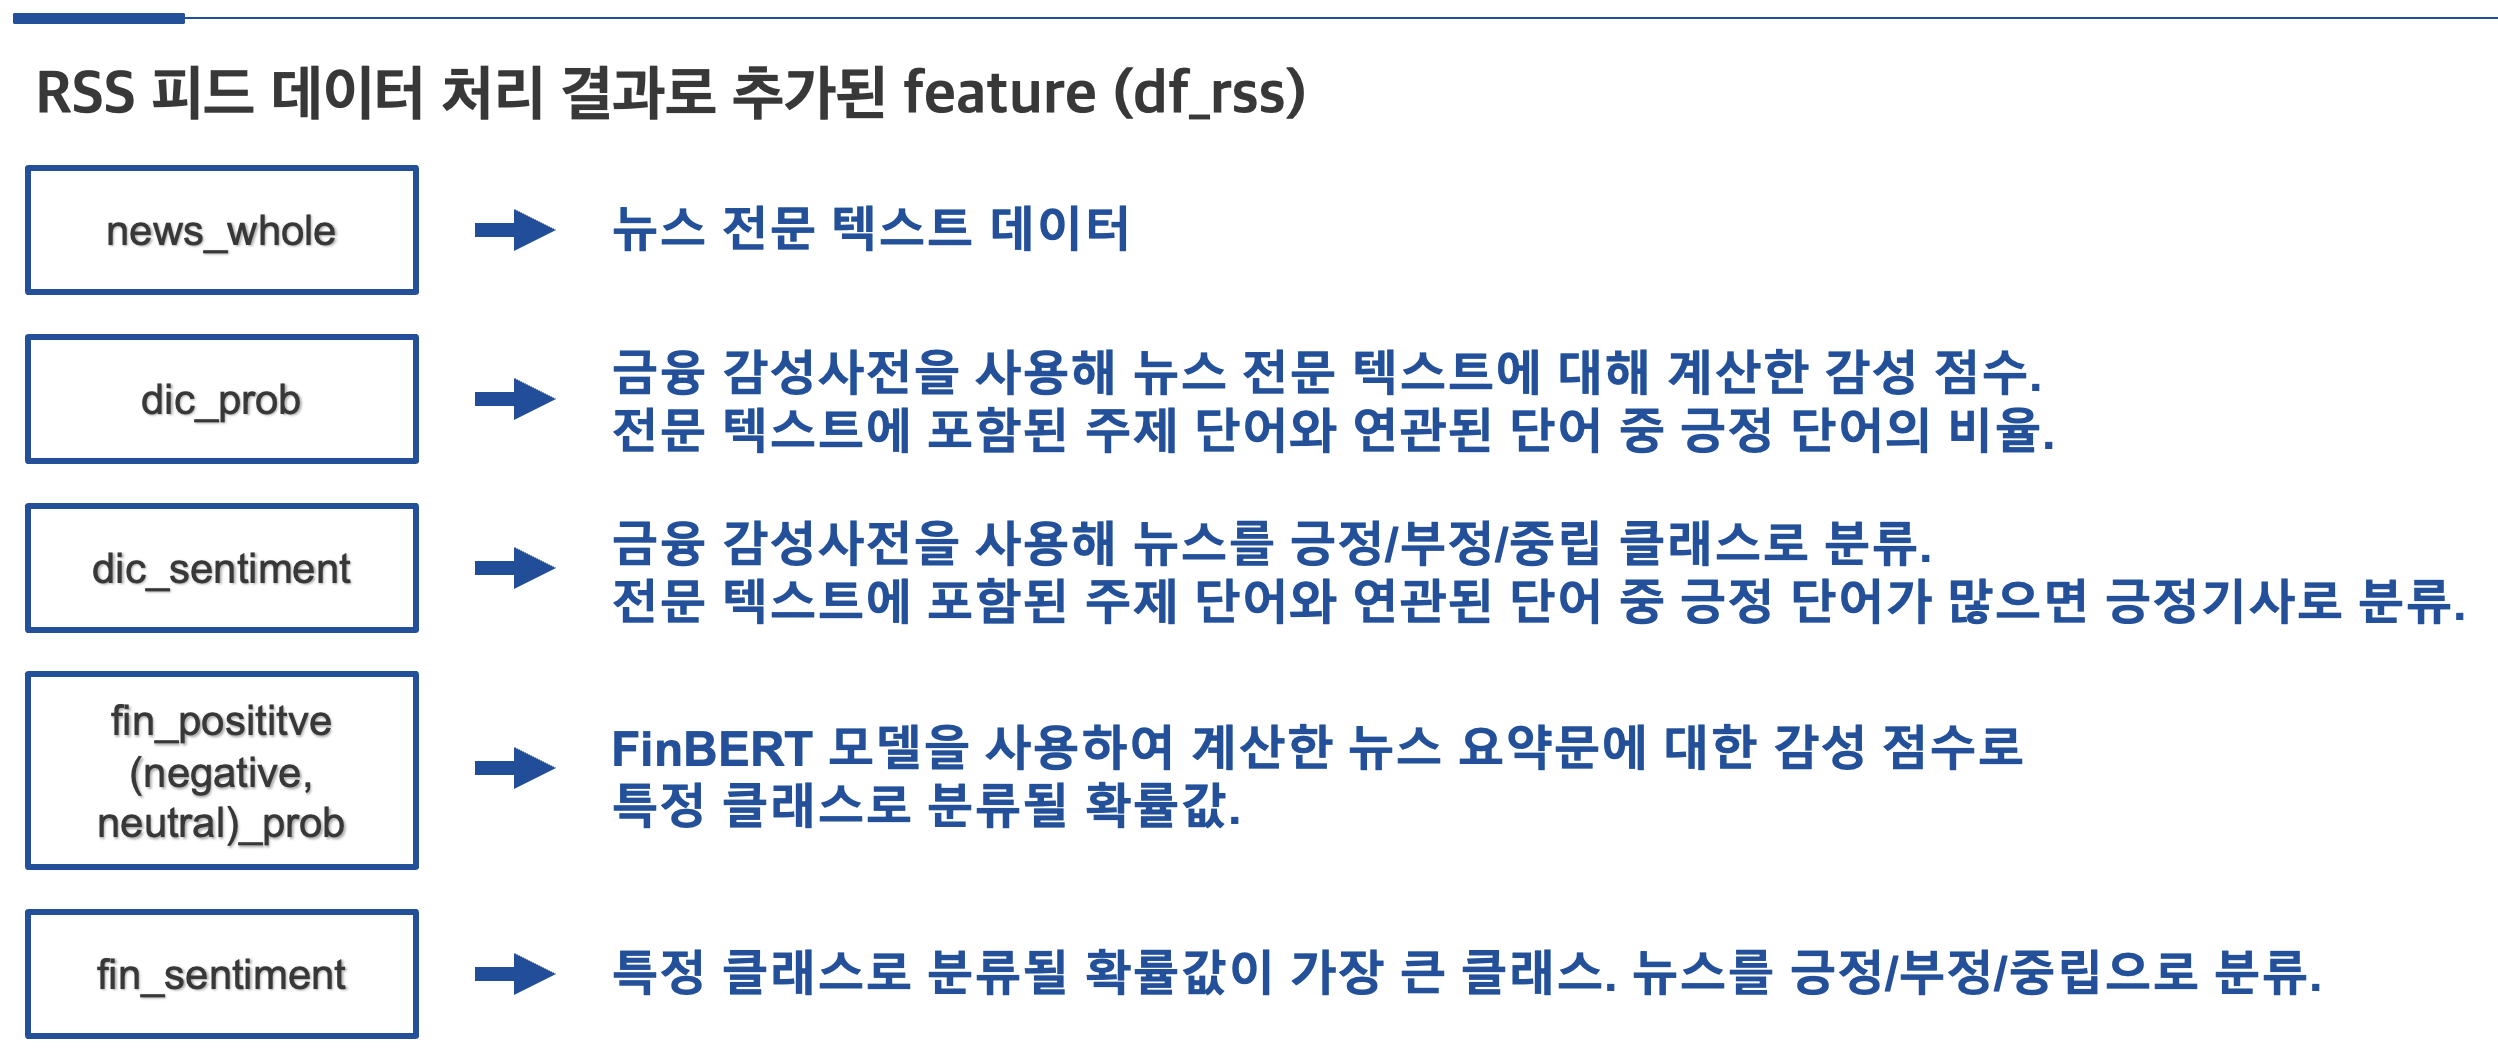

# **2. 국내여론 반응지수 제작**
- 사전학습된 BERT모델(smilegate-ai/kor_unsmile)을 사용함
- 데이터는 [혐오표현, 악플/욕설, clean]으로 분류될 수 있으며, 혐오 표현은 다중 레이블(multi-label)로 전문가 집단을 통해 labeling됨.
- 이때 여론의 긍정적 반응을 clean, 부정적 반응을 혐오 및 악플/욕설로 구분, 그 외에는 중립적 반응으로 구분함
- 참고 링크 :  https://github.com/smilegate-ai/korean_unsmile_dataset

In [ ]:
df_psy = pd.read_csv('data_files/naverroom_crawling.csv')
df_psy = df_psy[(df_psy['date'].str[:7] == '2023.01')| (df_psy['date'].str[:7] == '2023.02')| (df_psy['date'].str[:7] == '2023.03')| (df_psy['date'].str[:7] == '2023.04')|(df_psy['date'].str[:7] == '2023.05')|(df_psy['date'].str[:7] == '2023.06')|(df_psy['date'].str[:7] == '2023.07')|(df_psy['date'].str[:7] == '2023.08')].reset_index(drop=True)
df_psy.head()

In [ ]:
df_psy["full_comment"] = df_psy["title"] + " " + df_psy["comment"]

In [ ]:
temp = clean_text(df_psy['full_comment']) #메소드 적용
df_psy['full_comment'] = temp
df_psy.head()

,title,comment,date,ticker,full_comment
0,으음~,27달라를 외치던 때가 있었네? ㅋ\n,2023.03.08.,AACG,으음 달라를 외치던 때가 있었네 ㅋ
1,여긴 아무도 없나요?,..\n,2023.02.18.,AACG,여긴 아무도 없나요
2,미친,OOO \n,2023.08.30.,AAL,미친 ooo
3,"파월 ""물가 안정 위해 아직 연준이 할 일 많다""",파월 의장은 25일(현지시간) 와이오밍주 잭슨홀에서 열린 연례 경제정책 심포지엄 연...,2023.08.28.,AAL,파월 물가 안정 위해 아직 연준이 할 일 많다 파월 의장은 일현지시간 와이오밍주 잭...
4,파월 '잭슨홀 미팅' 연설에서 '고금리 장기화' 월가 긴장,FOMC 7월 회의에서 매파가 재 등장한대 이어 전세계 주식 시장은 이번주 현지시간...,2023.08.25.,AAL,파월 잭슨홀 미팅 연설에서 고금리 장기화 월가 긴장 fomc 월 회의에서 매파가 재...


In [ ]:
# 감성 분석을 위한 pretrained model 불러오기
# GPU 환경 필요
! pip install transformers
! pip install datasets==1.17.0

In [ ]:
from datasets import load_dataset
from transformers import BertForSequenceClassification, TrainingArguments, Trainer, AutoTokenizer
import torch
import numpy as np

dataset = load_dataset('smilegate-ai/kor_unsmile')

In [ ]:
from transformers import TextClassificationPipeline, BertForSequenceClassification, AutoTokenizer

model_name = 'smilegate-ai/kor_unsmile'

model = BertForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

pipe = TextClassificationPipeline(
    model=model,
    tokenizer=tokenizer,
    device=0,     # cpu: -1, gpu: gpu number  T4 GPU로 설정해야함 !
    return_all_scores=True,
    function_to_apply='sigmoid'
    )

In [ ]:
for result in pipe("개꿀"):
  hate = 1-list(result[9].values())[1]
  clean = list(result[9].values())[1]
  print(hate)
  print(clean)

0.09828925132751465
0.9017107486724854


- hate: 0.09828925132751465
- clean: 0.9017107486724854

In [ ]:
temp_hate = []
temp_clean = []
temp_neutral = []

for i in tqdm(range(len(df_psy))) :
  try :
    hate, clean = 0,0
    for result in pipe(df_psy['full_comment'][i]) :
      hate = 1-list(result[9].values())[1]
      clean = list(result[9].values())[1]
    temp_hate.append(hate)
    temp_clean.append(clean)
    temp_neutral.append(0)
  except :
    temp_hate.append(0)
    temp_clean.append(0)
    temp_neutral.append(1)

df_psy['psy_hate_prob'] = temp_hate
df_psy['psy_clean_prob'] = temp_clean
df_psy['psy_neutral_prob'] = temp_neutral

  0%|          | 5/24075 [00:00<22:35, 17.75it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 24075/24075 [06:02<00:00, 66.44it/s]


In [ ]:
def f1_psy(df):
    if df['psy_neutral_prob'] == 1 :
        val = 'neutral' #neutral
    elif df['psy_hate_prob'] > 0.5 :
        val = 'hate' #negative
    elif df['psy_clean_prob'] >= 0.5 :
        val = 'clean' #positive
    return val

df_psy['psy_sentiment']  = df_psy.apply(f1_psy, axis=1)

In [ ]:
df_psy.to_csv("data_files/naverroom_crawling_scoring_finnish.csv", index=False)

# **3. Feature Engineering**

우선 나스닥 종목의 시세 정보가 저장되어 있는 데이터를 불러옴. 이 데이터를 train data의 기본 프레임으로 사용함.

In [ ]:
df_stock = pd.read_csv('data_files/open/NASDAQ_DT_FC_STK_QUT.csv', encoding='cp949')
# 날짜 형식으로 변경
df_stock['trd_dt'] = pd.to_datetime(df_stock['trd_dt'].astype('str'))
# 사용할 날짜만 인덱싱
df_stock = df_stock[df_stock['trd_dt']>='2023-08-01'].reset_index(drop=True)
df_stock.head()

,trd_dt,tck_iem_cd,gts_iem_ong_pr,gts_iem_hi_pr,gts_iem_low_pr,gts_iem_end_pr,gts_acl_trd_qty,gts_sll_cns_sum_qty,gts_byn_cns_sum_qty
0,2023-08-01,HTCR,1.48,1.4800,1.330,1.35,32901.0,18224.0,14677.0
1,2023-08-01,INTU,510.56,510.5600,502.830,508.50,1495968.0,1126433.0,500009.0
2,2023-08-01,PETZ,1.29,1.3400,1.240,1.30,9357.0,2139.0,7218.0
3,2023-08-01,AXON,184.45,186.0499,183.260,183.33,425596.0,164982.0,260614.0
4,2023-08-01,CGABL,17.98,18.0320,17.855,17.98,15779.0,7741.0,8038.0


이후에는 아래와 같은 순서로 피쳐를 추가 및 매핑함. (코드가 길어 생략함)
- **step1. sector feature**
  - 이 feature는 이후에 sector 데이터를 받게 되면 그 데이터로 수정할 예정
  - 이해를 돕기 위해 임의로 크롤링한 데이터를 추가함
- **step2. 감성 지수 feature**
  - Part 1(감성사전기반, FinBERT기반 감성지수)에서 분석한 감성 지수를 불러와 시세 정보에 추가
  - 감성점수 데이터가 실제 종목 시세 데이터에 비해 많이 적으므로 결측행을 어느정도 채워줘야 함. 또한 종목의 가격은 그날 하루뿐만 아니라 과거 정보에도 영향을 받는다는 점을 감안하여, 당일을 포함한 **5일**의 감성점수도 가중평균 형태로 반영함.
  - 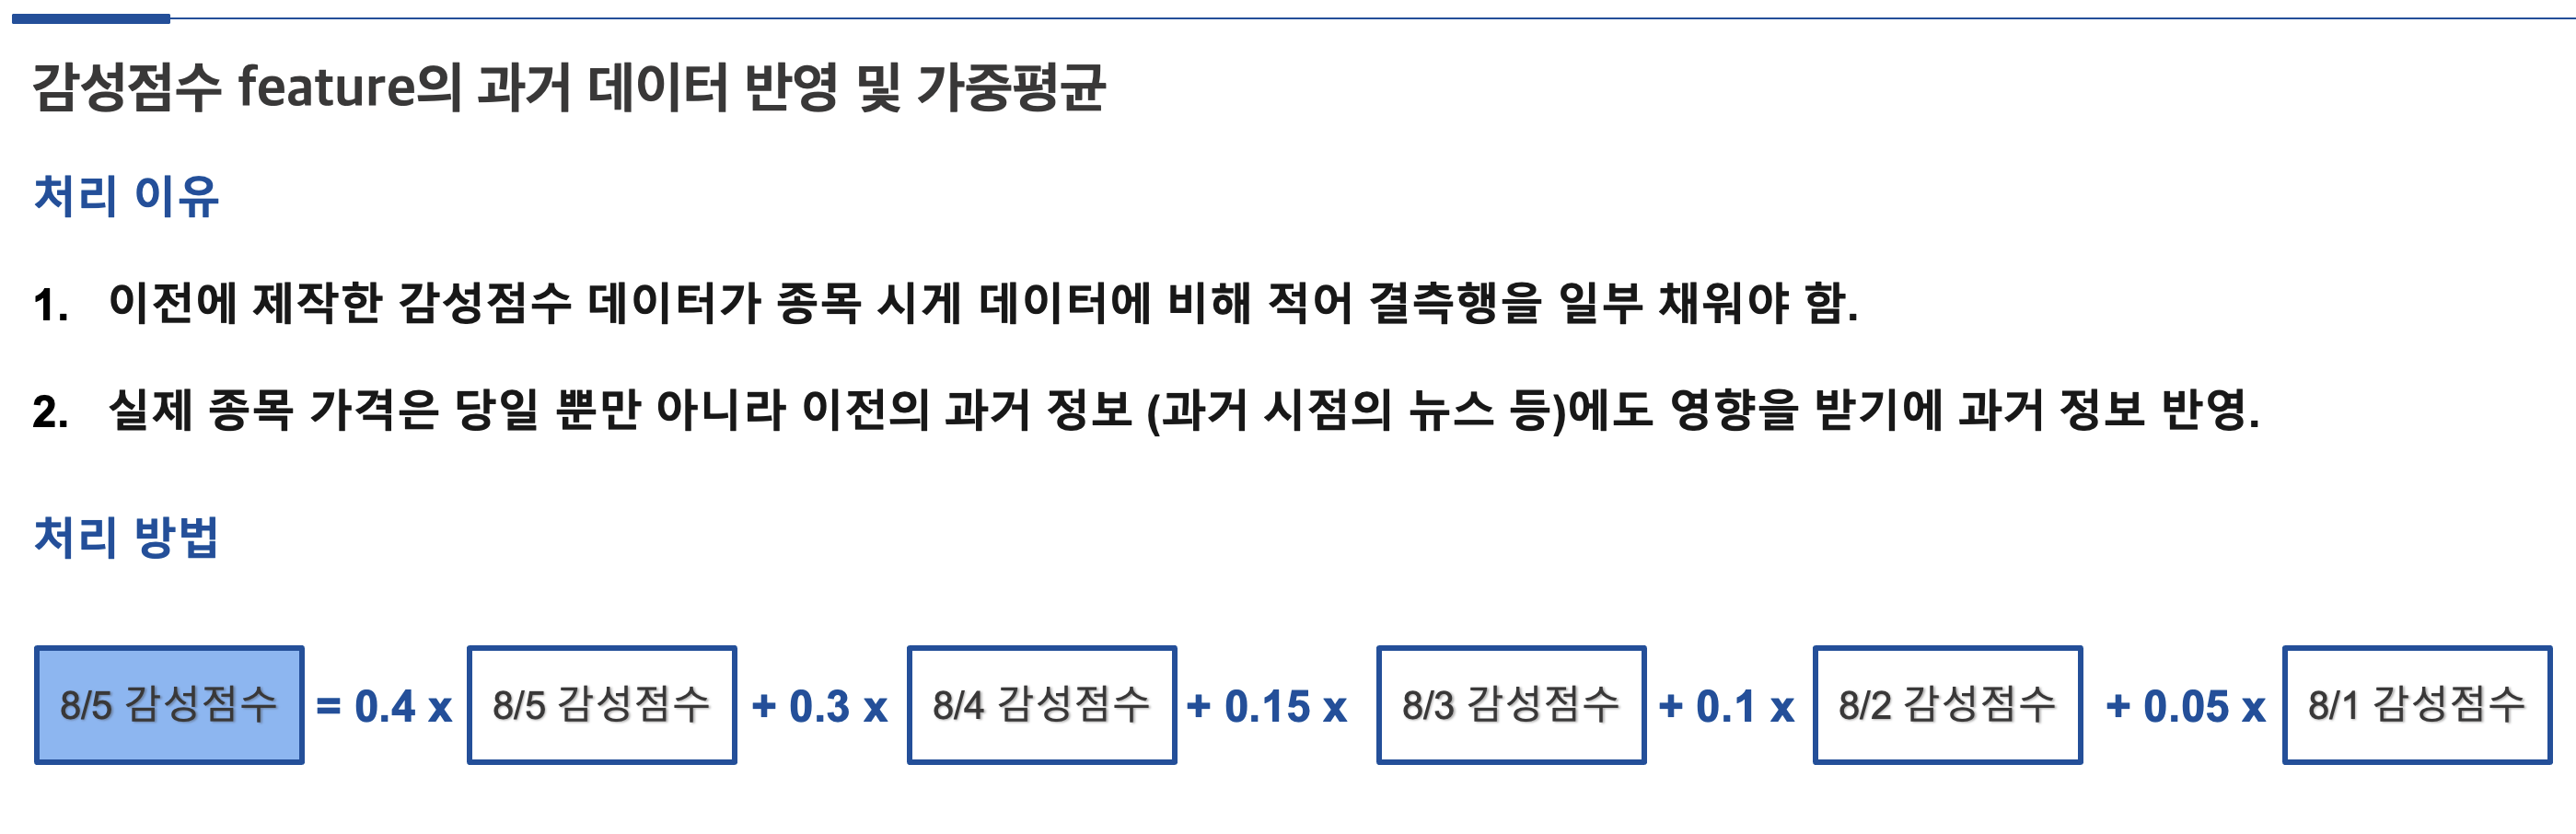

- **step3. 외부데이터 feature**
  - 거시경제 지표(주요국 증시, 금리, 환율, 유가) 수집
  - 출처 : 주미국 대한민국 대사관 > 한미관계 > 주간 경제지표 링크
  - https://www.mofa.go.kr/us-ko/brd/m_24540/list.do

- **step4. 거래량 추세 feature**
  - EDA 결과, 종가의 추세는 거래량과 가장 높은 연관성을 보임
  - 따라서 거래량의 추세를 feature로 추가하기로 결정
  - 이때 거래량은 감성지수처럼 과거의 정보도 반영할 수 있기 때문에 가중평균 형태로 반영함

- **step5. 반응지수 feature**
  - Part 2에서 분석한 네이버 종목 토론방의 반응지수를 불러와 시세 정보에 추가
  - 반응지수도 감성지수와 같은 가중평균 형태로 반영함

- **step6. 관련 종목 feature**
  - 나스닥의 RSS 피드 데이터는 관련 종목 정보를 제공함.
  - 주가는 사업 상 관련되어 있는 종목의 영향도 받기 때문에 관련 종목의 정보도 반영하였음
  - 해당일의 뉴스에서 언급된 모든 관련 종목의 top_sentiment 중 최빈값을 계산하여 사용
  - 이후 블룸버그 제공 공급망/경쟁사 데이터로 대체할 예정

- **step7. 결측치 대체, 카테고리 인코딩**
  - object 변수인 rld_ose_iem_tck_cd, sector는 공백으로 대체 후 인코딩
  - 감성지수, 반응지수 feature는 0, 1, 2 중 어느 것에도 해당하지 않는 3으로 대체


  

완성된 데이터는 다음과 같음.

In [ ]:
pd.options.display.max_columns = None
data = pd.read_csv("data_files/train_data.csv")
data['trd_dt'] = pd.to_datetime(data['trd_dt'].astype('str'))

data.head()

,trd_dt,tck_iem_cd,dic_prob,dic_count,dic_top_sentiment,fin_positive_prob,fin_negative_prob,fin_neutral_prob,fin_count,fin_top_sentiment,DOW,DOW_p,NASDAQ,NASDAQ_p,SP,SP_p,KOSPI,KOSPI_p,SANGHAI,SANGHAI_p,NIKKEI,NIKKEI_p,FTSE100,FTSE100_p,DAX,DAX_p,NOTE_3y,NOTE_3y_p,NOTE_10y,NOTE_10y_p,BOND_30y,BOND_30y_p,LIBOR,LIBOR_p,MORTAGE_RATE,MORTAGE_RATE_p,WON,WON_p,YUAN,YUAN_p,EUR,EUR_p,GBP,GBP_p,CNY,CNY_p,WTI,WTI_p,DUBAI,DUBAI_p,BRENT,BRENT_p,ma_acl_trd,ma_sll_cns,ma_byn_cns,psy_hate_prob,psy_clean_prob,psy_neutral_prob,psy_count,psy_top_sentiment,rld_count,rld_dic_sentiment,rld_fin_sentiment,sector_Basic Materials,sector_Consumer Discretionary,sector_Consumer Staples,sector_Energy,sector_Finance,sector_Health Care,sector_Industrials,sector_Miscellaneous,sector_None,sector_Real Estate,sector_Technology,sector_Telecommunications,sector_Utilities,fluctuation
180,2023-08-11,11,0.615533,2.0,0.0,0.475531,0.093201,0.431267,2.0,0.0,35176.15,-0.0055,15128.84,-0.0206,4468.83,-0.0116,2591.26,-0.0044,3189.25,-0.0301,32473.65,0.0087,7521.43,-0.0020,15850.19,-0.0033,4.47,-0.0002,4.09,-0.0003,4.24,0.0023,5.63,0.0,7.14,-0.0001,1330.28,0.0205,144.84,0.0216,0.9122,0.0043,0.7884,0.0059,7.3280,0.0094,82.88,0.0115,88.18,0.0961,86.61,0.0124,3977356.45,1996897.80,1987883.65,0.035267,0.264733,0.0,0.0,3.0,0.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
181,2023-08-14,11,0.582081,2.0,0.0,0.357832,0.043209,0.598959,2.0,2.0,34474.83,-0.0199,14715.81,-0.0273,4370.36,-0.0225,2504.50,-0.0335,3131.95,-0.0180,31450.76,-0.0315,7227.65,-0.0391,15499.48,-0.0221,4.67,0.0004,4.30,0.0005,4.41,0.0025,5.64,0.0,7.37,0.0003,1342.82,0.0094,145.42,0.0040,0.9206,0.0092,0.7857,-0.0034,7.2893,0.0071,80.16,-0.0328,85.68,-0.0284,83.68,-0.0338,3762251.60,1745227.35,2022214.05,0.017633,0.132367,0.0,0.0,3.0,0.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
182,2023-08-15,11,0.507368,1.0,1.0,0.242526,0.034632,0.722842,1.0,2.0,34474.83,-0.0199,14715.81,-0.0273,4370.36,-0.0225,2504.50,-0.0335,3131.95,-0.0180,31450.76,-0.0315,7227.65,-0.0391,15499.48,-0.0221,4.67,0.0004,4.30,0.0005,4.41,0.0025,5.64,0.0,7.37,0.0003,1342.82,0.0094,145.42,0.0040,0.9206,0.0092,0.7857,-0.0034,7.2893,0.0071,80.16,-0.0328,85.68,-0.0284,83.68,-0.0338,3775489.60,1945259.45,1833443.75,0.063835,0.436165,0.0,1.0,0.0,0.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
183,2023-08-16,11,0.555836,2.0,0.0,0.169516,0.214507,0.615977,2.0,1.0,34474.83,-0.0199,14715.81,-0.0273,4370.36,-0.0225,2504.50,-0.0335,3131.95,-0.0180,31450.76,-0.0315,7227.65,-0.0391,15499.48,-0.0221,4.67,0.0004,4.30,0.0005,4.41,0.0025,5.64,0.0,7.37,0.0003,1342.82,0.0094,145.42,0.0040,0.9206,0.0092,0.7857,-0.0034,7.2893,0.0071,80.16,-0.0328,85.68,-0.0284,83.68,-0.0338,3645108.50,1796600.20,1849622.60,0.044938,0.305062,0.0,0.0,3.0,0.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
184,2023-08-17,11,0.562073,3.0,0.0,0.098498,0.409493,0.492009,3.0,1.0,34474.83,-0.0199,14715.81,-0.0273,4370.36,-0.0225,2504.50,-0.0335,3131.95,-0.0180,31450.76,-0.0315,7227.65,-0.0391,15499.48,-0.0221,4.67,0.0004,4.30,0.0005,4.41,0.0025,5.64,0.0,7.37,0.0003,1342.82,0.0094,145.42,0.0040,0.9206,0.0092,0.7857,-0.0034,7.2893,0.0071,80.16,-0.0328,85.68,-0.0284,83.68,-0.0338,3718057.05,1746381.35,1971921.90,0.019530,0.130470,0.0,0.0,3.0,0.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
185,2023-08-18,11,0.609973,2.0,0.0,0.338463,0.277795,0.383742,2.0,0.0,34474.83,-0.0199,14715.81,-0.0273,4370.36,-0.0225,2504.50,-0.0335,3131.95,-0.0180,31450.76,-0.0315,7227.65,-0.0391,15499.48,-0.0221,4.67,0.0004,4.30,0.0005,4.41,0.0025,5.64,0.0,7.37,0.0003,1342.82,0.0094,145.42,0.0040,0.9206,0.0092,0.7857,-0.0034,7.2893,0.0071,80.16,-0.0328,85.68,-0.0284,83.68,-0.0338,4624270.80,2067722.30,2556671.60,0.013020,0.086980,0.0,0.0,3.0,0.0,3.0,3.0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
186,2023-08-21,11,0.569343,2.0,1.0,0.452886,0.167233,0.379881,2.0,0.0,34262.21,-0.0062,14886.35,0.0116,4395.63,0.0057,2519.14,0.0058,3064.07,-0.0217,31624.28,0.0055,7369.85,0.0197,15698.56,0.0128,4.69,0.0000,4.23,-0.0002,4.30,0.0022,5.64,0.0,7.37,0.0000,1323.54,-0.0144,146.11,0.0047,0.9

## target feature : **주가방향성** 만들기

- 단순히 다음 날의 종가 자체 또는 종가의 등락을 예측하는 것은 큰 의미가 없다고 판단
- 주식은 계속 변화하기 때문에 당장 내일의 정보보다는 미래의 '추세'를 알려주는 것이 더 효용성이 높을 것
- 따라서 3일 간 종가로 회귀계수를 계산하고, 회귀계수의 부호에 따라 증가/감소를 분류함
- 이 분류값을 target 변수로 이용함으로써, 우리의 모델이 당장 내일 하루의 정보가 아닌, 3일 간의 추세에 대한 정보를 예측함

In [ ]:
from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.preprocessing import *

In [ ]:
data = pd.read_csv("data_files/train_data.csv")
data['trd_dt'] = pd.to_datetime(data['trd_dt'].astype('str'))
# 7월은 뉴스 데이터를 수집하지 않았기 때문에 8/1~8/4의 감성분석 가중평균 데이터는 불완전하다. 따라서 제외.
data = data[data['trd_dt']>'2023-08-04']

In [ ]:
make_y_data = pd.DataFrame()

for ticker in set(data['tck_iem_cd']) :
    fluct = []
    ticker_data = data[data['tck_iem_cd'] == ticker]
    for i in range(len(ticker_data)-2) :
        m, b = np.polyfit(np.array([1,2,3]), np.array(list(ticker_data['gts_iem_end_pr'].iloc[i:i+3].values)), 1)
        if m > 0 :
            fluct.append(1)
        else :
            fluct.append(0)
    # y변수를 만들 수 없는 8/29, 8/30 제외
    ticker_data = ticker_data.iloc[:16]
    ticker_data['fluctuation'] = fluct
    make_y_data = pd.concat([make_y_data, ticker_data], ignore_index = True)

In [ ]:
make_y_data = make_y_data.drop(columns = ['gts_iem_end_pr'])
make_y_data.head()

,trd_dt,tck_iem_cd,rld_ose_iem_tck_cd,sector,dic_prob,dic_count,dic_top_sentiment,fin_positive_prob,fin_negative_prob,fin_neutral_prob,...,BRENT_p,ma_acl_trd,ma_sll_cns,ma_byn_cns,psy_hate_prob,psy_clean_prob,psy_neutral_prob,psy_count,psy_top_sentiment,fluctuation
0,2023-08-07,PALT,"XPEV,ACHR,AUPH,MRUS,TRUP,GHSI,RNLX,BHG,BDTX,WA...",Consumer Discretionary,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0124,24395.25,11001.9,13393.35,0.0,0.0,0.0,NaN,NaN,1
1,2023-08-08,PALT,"XPEV,ACHR,AUPH,MRUS,TRUP,GHSI,RNLX,BHG,BDTX,WA...",Consumer Discretionary,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0124,24536.15,12157.0,12379.15,0.0,0.0,0.0,NaN,NaN,1
2,2023-08-09,PALT,"XPEV,ACHR,AUPH,MRUS,TRUP,GHSI,RNLX,BHG,BDTX,WA...",Consumer Discretionary,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0124,135564.60,56001.5,79563.10,0.0,0.0,0.0,NaN,NaN,1
3,2023-08-10,PALT,"XPEV,ACHR,AUPH,MRUS,TRUP,GHSI,RNLX,BHG,BDTX,WA...",Consumer Discretionary,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0124,258829.80,95555.3,163274.50,0.0,0.0,0.0,NaN,NaN,0
4,2023-08-11,PALT,"XPEV,ACHR,AUPH,MRUS,TRUP,GHSI,RNLX,BHG,BDTX,WA...",Consumer Discretionary,0.0,NaN,NaN,0.0,0.0,0.0,...,0.0124,208728.55,75178.2,133550.35,0.0,0.0,0.0,NaN,NaN,0


In [ ]:
make_y_data.to_csv("data_files/train_data.csv", index=False)

# **Service 1. Model Training : 예측모델링**
- 우선 최적의 예측모델 선정을 위해 automl을 돌려 결과를 확인하는 과정을 거침
- 그 결과 **1) Gradient Boosting Classifier 2) Lgbm 3) Ada Boost Classifier** 3가지 상위 모델을 선정
- 각각의 모델에 대하여 모든 피쳐를 대상으로 GridSearch -> 피쳐 중요도의 상위 5, 10, 20개의 변수 선택 -> 하이퍼파라미터 튜닝 -> 최종 피쳐, 파라미터 선정 순서로 진행
- 이후 앙상블 (voting-hard / voting - soft / stacking / boosting)기법을 실시했지만 **BEST는 단일 Gradient Boosting Classifier && 상위 피쳐 10개의 조합**으로 결론 !!
- cross validation 실시 결과, **acc = 65.52%**

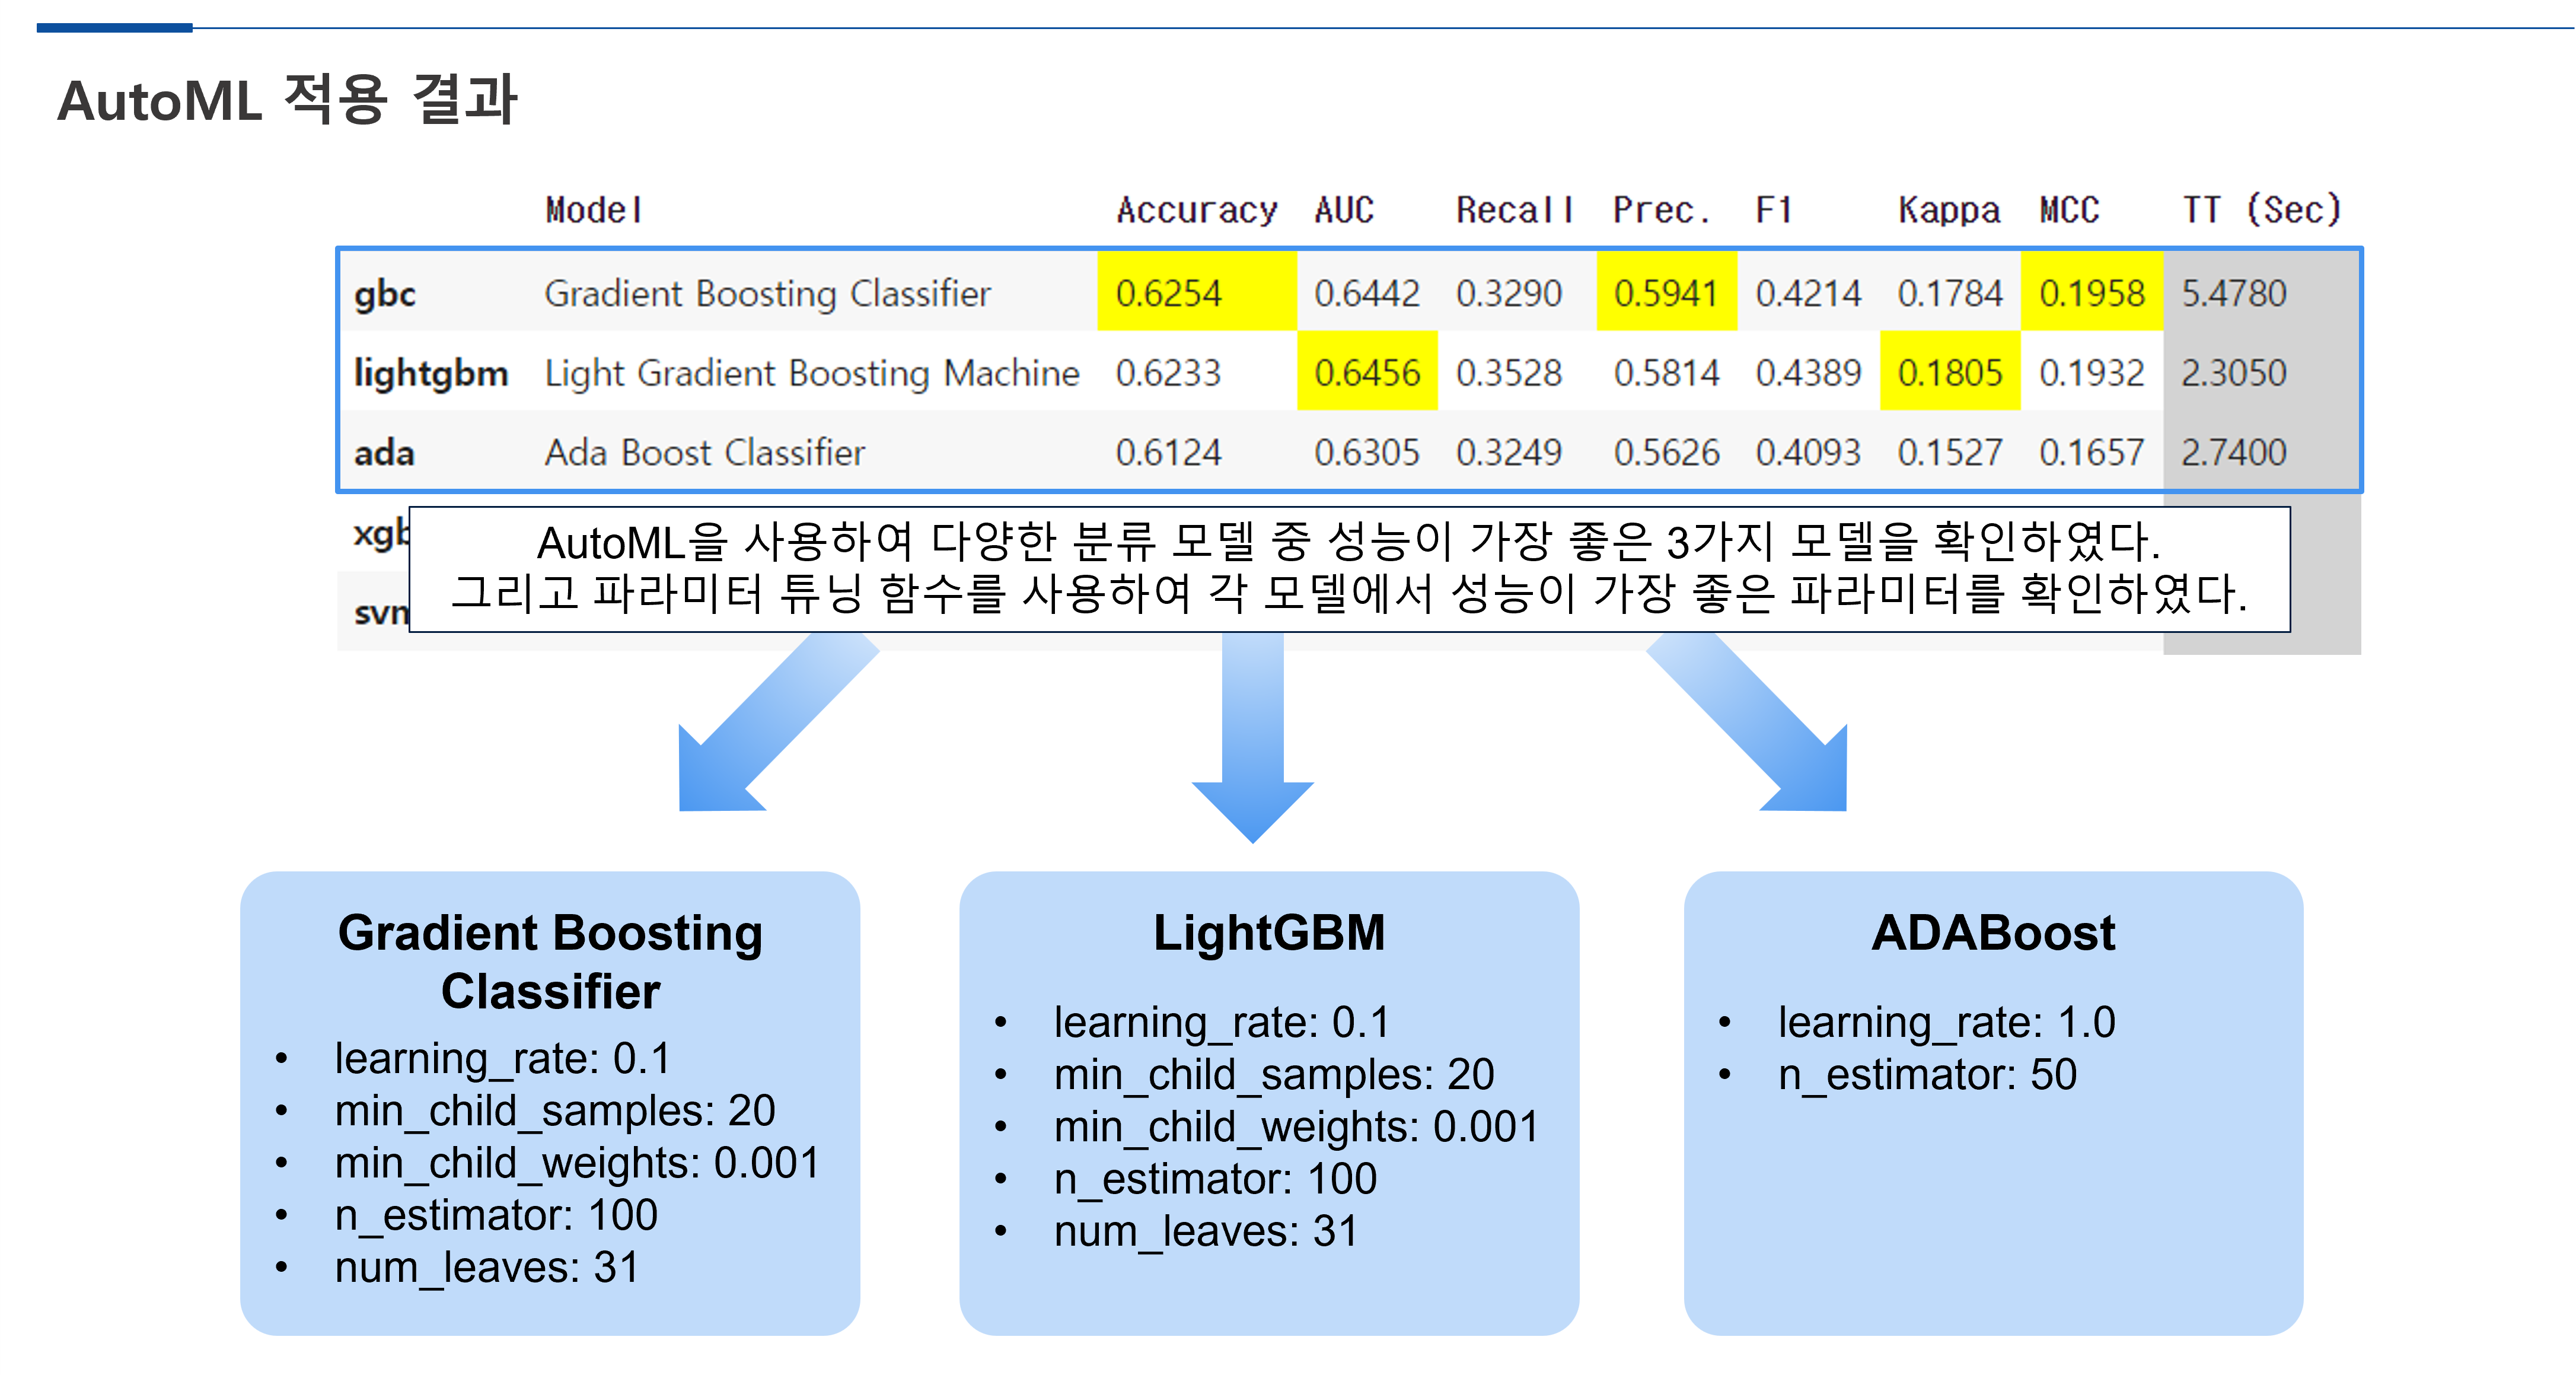

In [ ]:
from sklearn.preprocessing import *
from sklearn.compose import *
from sklearn.model_selection import *
from sklearn.metrics import *
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [ ]:
# scaling
data = pd.read_csv("/content/drive/MyDrive/NH/prediction/train_data.csv")
data['trd_dt'] = pd.to_datetime(data['trd_dt'].astype('str'))
data['trd_dt'] = data['trd_dt'].dt.day

nominal_cols = ['trd_dt', 'tck_iem_cd', 'dic_count', 'dic_top_sentiment',
                'fin_count', 'fin_top_sentiment', 'psy_count', 'psy_top_sentiment',
                'sector_Basic Materials','sector_Consumer Discretionary',
                'sector_Consumer Staples','sector_Energy', 'sector_Finance', 'sector_Health Care',
                'sector_Industrials', 'sector_Miscellaneous', 'sector_None','sector_Real Estate',
                'sector_Technology', 'sector_Telecommunications','sector_Utilities', 'fluctuation']

numerical_cols = [col for col in data.columns if col not in nominal_cols]

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numerical_cols])

scaled_df = pd.DataFrame(scaled_data, columns=numerical_cols)

scaled_df[nominal_cols] = data[nominal_cols]

scaled_df.head()

In [ ]:
#scaled_df.to_csv("/content/drive/MyDrive/NH/prediction/preprocess+scaled_data.csv", index = False)
#scaled_df = pd.read_csv("/content/drive/MyDrive/NH/prediction/preprocess+scaled_data.csv")

In [ ]:
# 공백이 있는 컬럼 _ 채우기

scaled_df.columns = scaled_df.columns.str.replace(" ", "_")
X = scaled_df.drop(columns = ['fluctuation'])
y = data['fluctuation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1) GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc_model = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}

grid_search = GridSearchCV(estimator=gbc_model, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [ ]:
gbc_full_best_params = grid_search.best_params_

gbc_full_model = GradientBoostingClassifier(**gbc_full_best_params)

gbc_full_model.fit(X_train, y_train)

gbc_full_y_pred = gbc_full_model.predict(X_test)
gbc_full_y_prob = gbc_full_model.predict_proba(X_test)[:, 1]

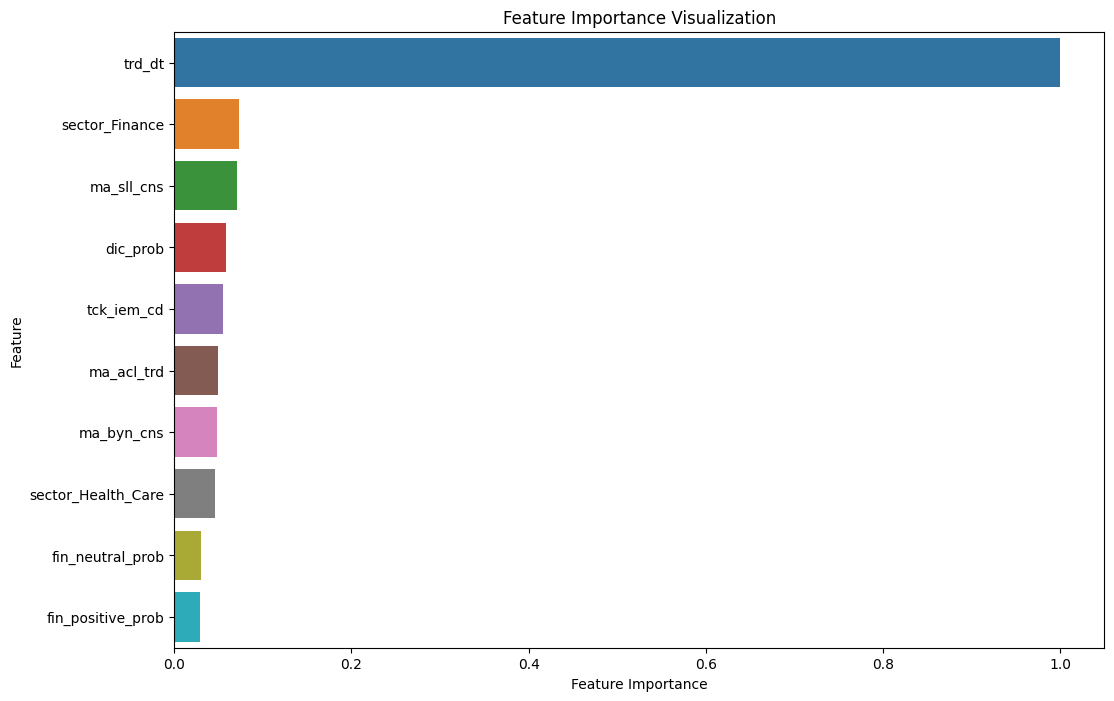

In [ ]:
gbc_feature_importances = gbc_full_model.feature_importances_

min_val = min(gbc_feature_importances)
max_val = max(gbc_feature_importances)

scaled_list = [(x - min_val) / (max_val - min_val) for x in gbc_feature_importances]

gbc_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': scaled_list})

gbc_importance_df = gbc_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=gbc_importance_df[:10])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Visualization')
plt.show()

In [ ]:
N = 10#향후 앙상블 진행을 위해 10으로 통일
selected_features = X.columns[np.argsort(gbc_feature_importances)[::-1][:N]]
X_selected = X[selected_features]
y = data['fluctuation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

estimator = GradientBoostingClassifier()

param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}

grid_search = GridSearchCV(estimator, param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

gbc_10_best_params = grid_search.best_params_
gbc_10_model = GradientBoostingClassifier(**gbc_10_best_params)
gbc_10_model.fit(X_train, y_train)

gbc_10_y_pred = gbc_10_model.predict(X_test)
gbc_10_y_prob = gbc_10_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, gbc_10_y_pred)
logloss = log_loss(y_test, gbc_10_y_prob)
precision = precision_score(y_test, gbc_10_y_pred, average='weighted')
recall = recall_score(y_test, gbc_10_y_pred, average='weighted')
f1 = f1_score(y_test, gbc_10_y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, gbc_10_y_pred)

Accuracy: 0.6552
LogLoss: 0.6261
Precision: 0.6545
Recall: 0.6552
f1: 0.6338
Confusion Matrix:  [[4308  769]
 [2258 1443]]


## 2) LGBM

In [ ]:
estimator = lgb.LGBMClassifier(objective='binary', force_row_wise = True)

# Grid Search를 위한 파라미터 그리드 정의
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator, param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

print("최적의 파라미터: ", grid_search.best_params_)

In [ ]:
lgbm_full_best_params = grid_search.best_params_
lgbm_full_model = lgb.LGBMClassifier(objective='binary', **lgbm_full_best_params, force_row_wise = True)
lgbm_full_model.fit(X_train, y_train)

lgbm_full_y_pred = lgbm_full_model.predict(X_test)
lgbm_full_y_prob = lgbm_full_model.predict_proba(X_test)[:, 1]

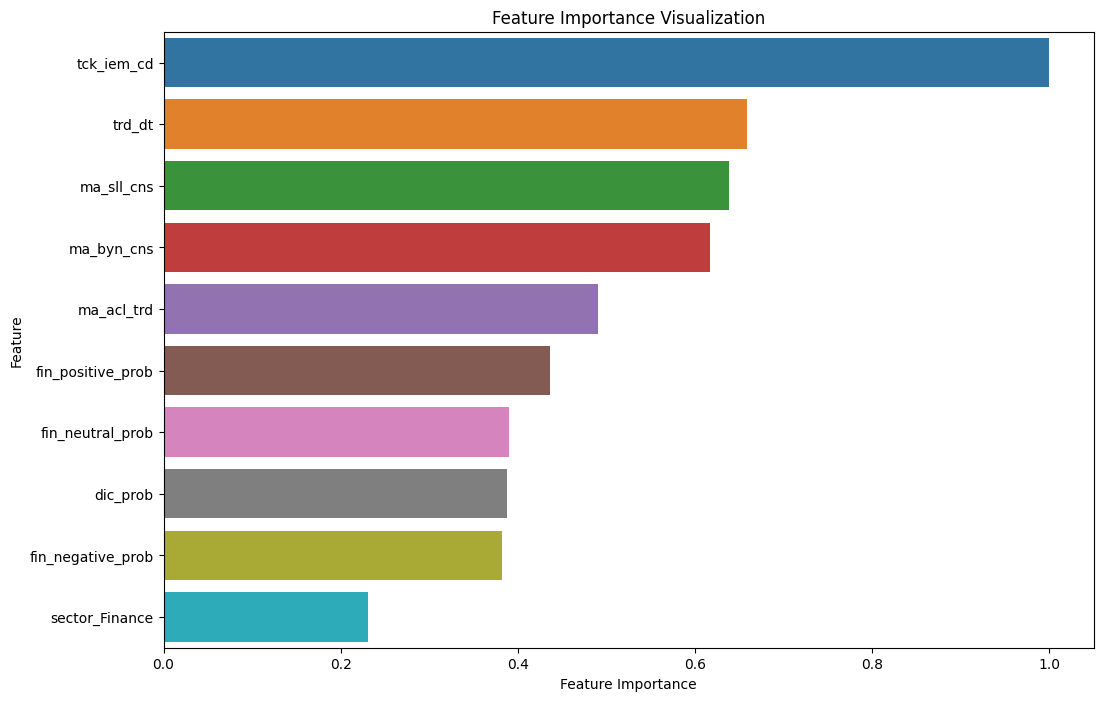

In [ ]:
lgbm_feature_importances = lgbm_full_model.feature_importances_

min_val = min(lgbm_feature_importances)
max_val = max(lgbm_feature_importances)

scaled_list = [(x - min_val) / (max_val - min_val) for x in lgbm_feature_importances]

lgbm_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': scaled_list})

lgbm_importance_df = lgbm_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=lgbm_importance_df[:10])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Visualization')
plt.show()

### Feature Selection 변수 10개 선택

In [ ]:
N = 10 #20, 15, 5로도 진행하였지만 10으로의 성능이 가장 좋음.
selected_features = X.columns[np.argsort(lgbm_feature_importances)[::-1][:N]]
X_selected = X[selected_features]
y = data['fluctuation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

estimator = lgb.LGBMClassifier(objective='binary', force_row_wise = True)

# Grid Search를 위한 파라미터 그리드 정의
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200]
}

grid_search = GridSearchCV(estimator, param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

lgbm_10_best_params = grid_search.best_params_
lgbm_10_model = lgb.LGBMClassifier(objective='binary', **lgbm_10_best_params, force_row_wise = True)
lgbm_10_model.fit(X_train, y_train)

lgbm_10_y_pred = lgbm_10_model.predict(X_test)
lgbm_10_y_prob = lgbm_10_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, lgbm_10_y_pred)
logloss = log_loss(y_test, lgbm_10_y_prob)
precision = precision_score(y_test, lgbm_10_y_pred, average='weighted')
recall = recall_score(y_test, lgbm_10_y_pred, average='weighted')
f1 = f1_score(y_test, lgbm_10_y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, lgbm_10_y_pred)

Accuracy: 0.6535
LogLoss: 0.6231
Precision: 0.6520
Recall: 0.6535
f1: 0.63
Confusion Matrix:  [[4286  791]
 [2251 1450]]

## 3) ADA BOOST

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

adb_model = AdaBoostClassifier()

param_grid = {
    'n_estimators': [30, 50, 100],
    'learning_rate': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(estimator=adb_model, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)
print("최적의 파라미터: ", grid_search.best_params_)

최적의 파라미터:  {'learning_rate': 0.5, 'n_estimators': 100}


In [ ]:
adb_full_best_params = grid_search.best_params_
adb_full_model = AdaBoostClassifier(**adb_full_best_params)
adb_full_model.fit(X_train, y_train)

adb_full_y_pred = adb_full_model.predict(X_test)
adb_full_y_prob = adb_full_model.predict_proba(X_test)[:, 1]

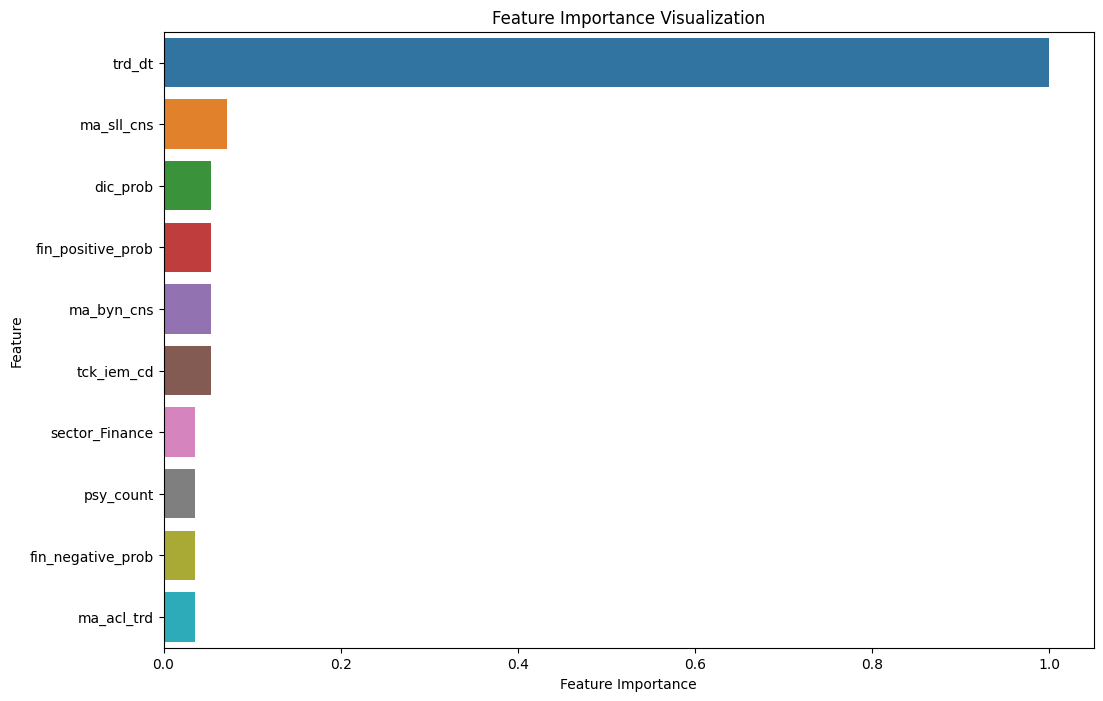

In [ ]:
adb_feature_importances = adb_full_model.feature_importances_

min_val = min(adb_feature_importances)
max_val = max(adb_feature_importances)

scaled_list = [(x - min_val) / (max_val - min_val) for x in adb_feature_importances]

adb_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': scaled_list})

adb_importance_df = adb_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=adb_importance_df[:10])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Visualization')
plt.show()

### Feature Selection 변수 10개 선택

In [ ]:
N = 10 #향후 앙상블 진행을 위해 10으로 통일
selected_features = X.columns[np.argsort(adb_feature_importances)[::-1][:N]]
X_selected = X[selected_features]
y = data['fluctuation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

estimator = AdaBoostClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.1, 0.5, 1.0]
}

grid_search = GridSearchCV(estimator, param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train, y_train)

adb_10_best_params = grid_search.best_params_
adb_10_model = AdaBoostClassifier(**adb_10_best_params)
adb_10_model.fit(X_train, y_train)

adb_10_y_pred = adb_10_model.predict(X_test)
adb_10_y_prob = adb_10_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, adb_10_y_pred)
logloss = log_loss(y_test, adb_10_y_prob)
precision = precision_score(y_test, adb_10_y_pred, average='weighted')
recall = recall_score(y_test, adb_10_y_pred, average='weighted')
f1 = f1_score(y_test, adb_10_y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, adb_10_y_pred)

Accuracy: 0.6448
LogLoss: 0.6909
Precision: 0.6444
Recall: 0.6448
f1: 0.6182
Confusion Matrix:  [[4352  725]
 [2393 1308]]


In [ ]:
print(lgbm_10_best_params)
print(adb_10_best_params)
print(gbc_10_best_params)

{'learning_rate': 0.05, 'n_estimators': 100, 'num_leaves': 50}
{'learning_rate': 0.5, 'n_estimators': 100}
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 100}


In [ ]:
lgbm_imp = lgbm_importance_df['Feature'][:12]
adb_imp = adb_importance_df['Feature'][:12]
gbc_imp = gbc_importance_df['Feature'][:12]

intersection = list(set(lgbm_imp) & set(adb_imp) & set(gbc_imp))
len(intersection)

10

## Ensemble을 통해 최종 피쳐들의 영향력 확인해보기!

ma_sll_cns
fin_negative_prob
trd_dt
fin_neutral_prob
sector_Finance
fin_positive_prob
ma_acl_trd
tck_iem_cd
dic_prob
ma_byn_cns


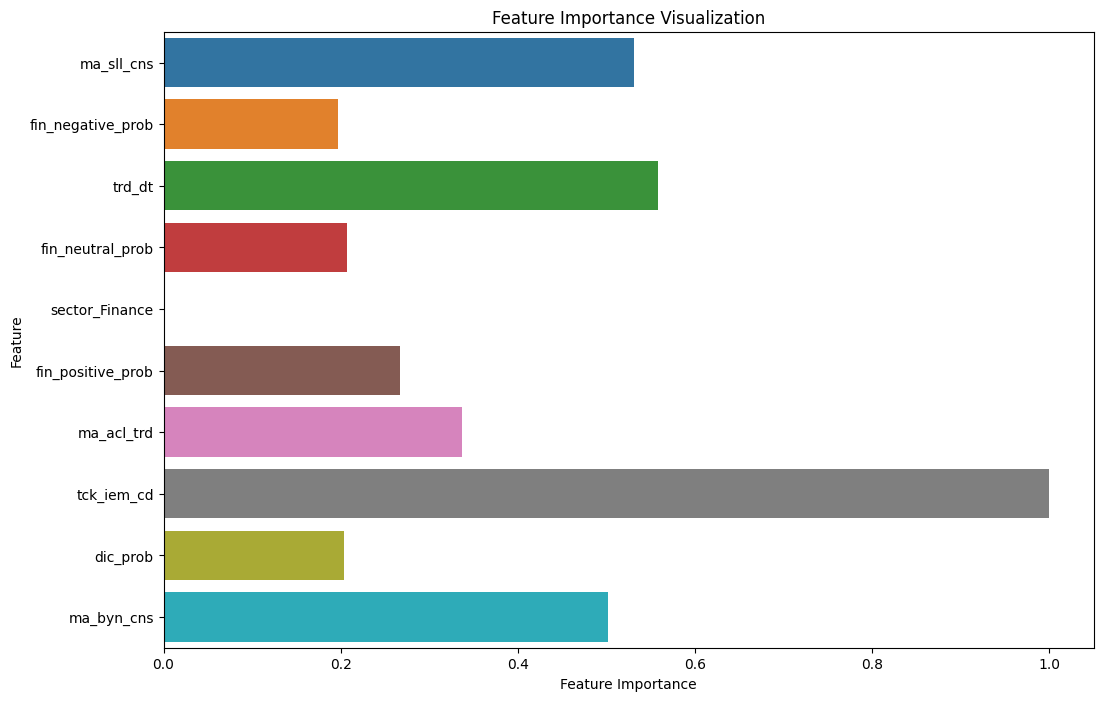

In [ ]:
# 변수 중요도 츨력
mean_imp = []

for feature in intersection :
    print(feature)
    mean_imp.append((lgbm_importance_df[lgbm_importance_df['Feature'] == feature]['Importance'].iloc[0] + adb_importance_df[adb_importance_df['Feature'] == feature]['Importance'].iloc[0] + gbc_importance_df[gbc_importance_df['Feature'] == feature]['Importance'].iloc[0])/3)

min_val = min(mean_imp)
max_val = max(mean_imp)

scaled_list = [(x - min_val) / (max_val - min_val) for x in mean_imp]

total_feature_imp = pd.DataFrame({'Feature' : intersection, 'Importance' : scaled_list})

# 스케일링 수행
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=total_feature_imp)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Visualization')
plt.show()

- 총 77개의 피쳐 중 **매도량, 매수량, 전체거래량, FinBERT기반 감성분류 확률값, 감성사전 기반 감성분류 확률값**이 사용한 상위 10개에 해당.
- **즉, 본 팀에서 생성한 감성지수 영향력이 높은 비중을 확인할 수 있음.**  
- 향후엔 현저히 부족했던 국내여론 데이터을 대표할 수 있는 데이터를 추가 크롤링해 보완할 예정

# **Service 2. 과거 주가등락에 대한 백트래킹**

- **과거의 주가 변화에 대한 원인을 파악(=back-tracking)**하기 위해 주가 등락을 가장 잘 설명하는 뉴스 기사를 제공하는 서비스
- 모델링1과 모델링2에서 제작한 감성분석지수와 모델링4에서 제작한 추세 예측 모델의 결과값이 일치하는 기사를 선별적으로 보여줌 (ex. 긍정-상승, 부정-하락이 일치하는 기사의 요약문 제공)
- 감성지수가 높은 순서대로 결과를 보여줌으로써 주가의 변화와 연관된 정보가 가장 많은 뉴스를 먼저 볼 수 있도록 함

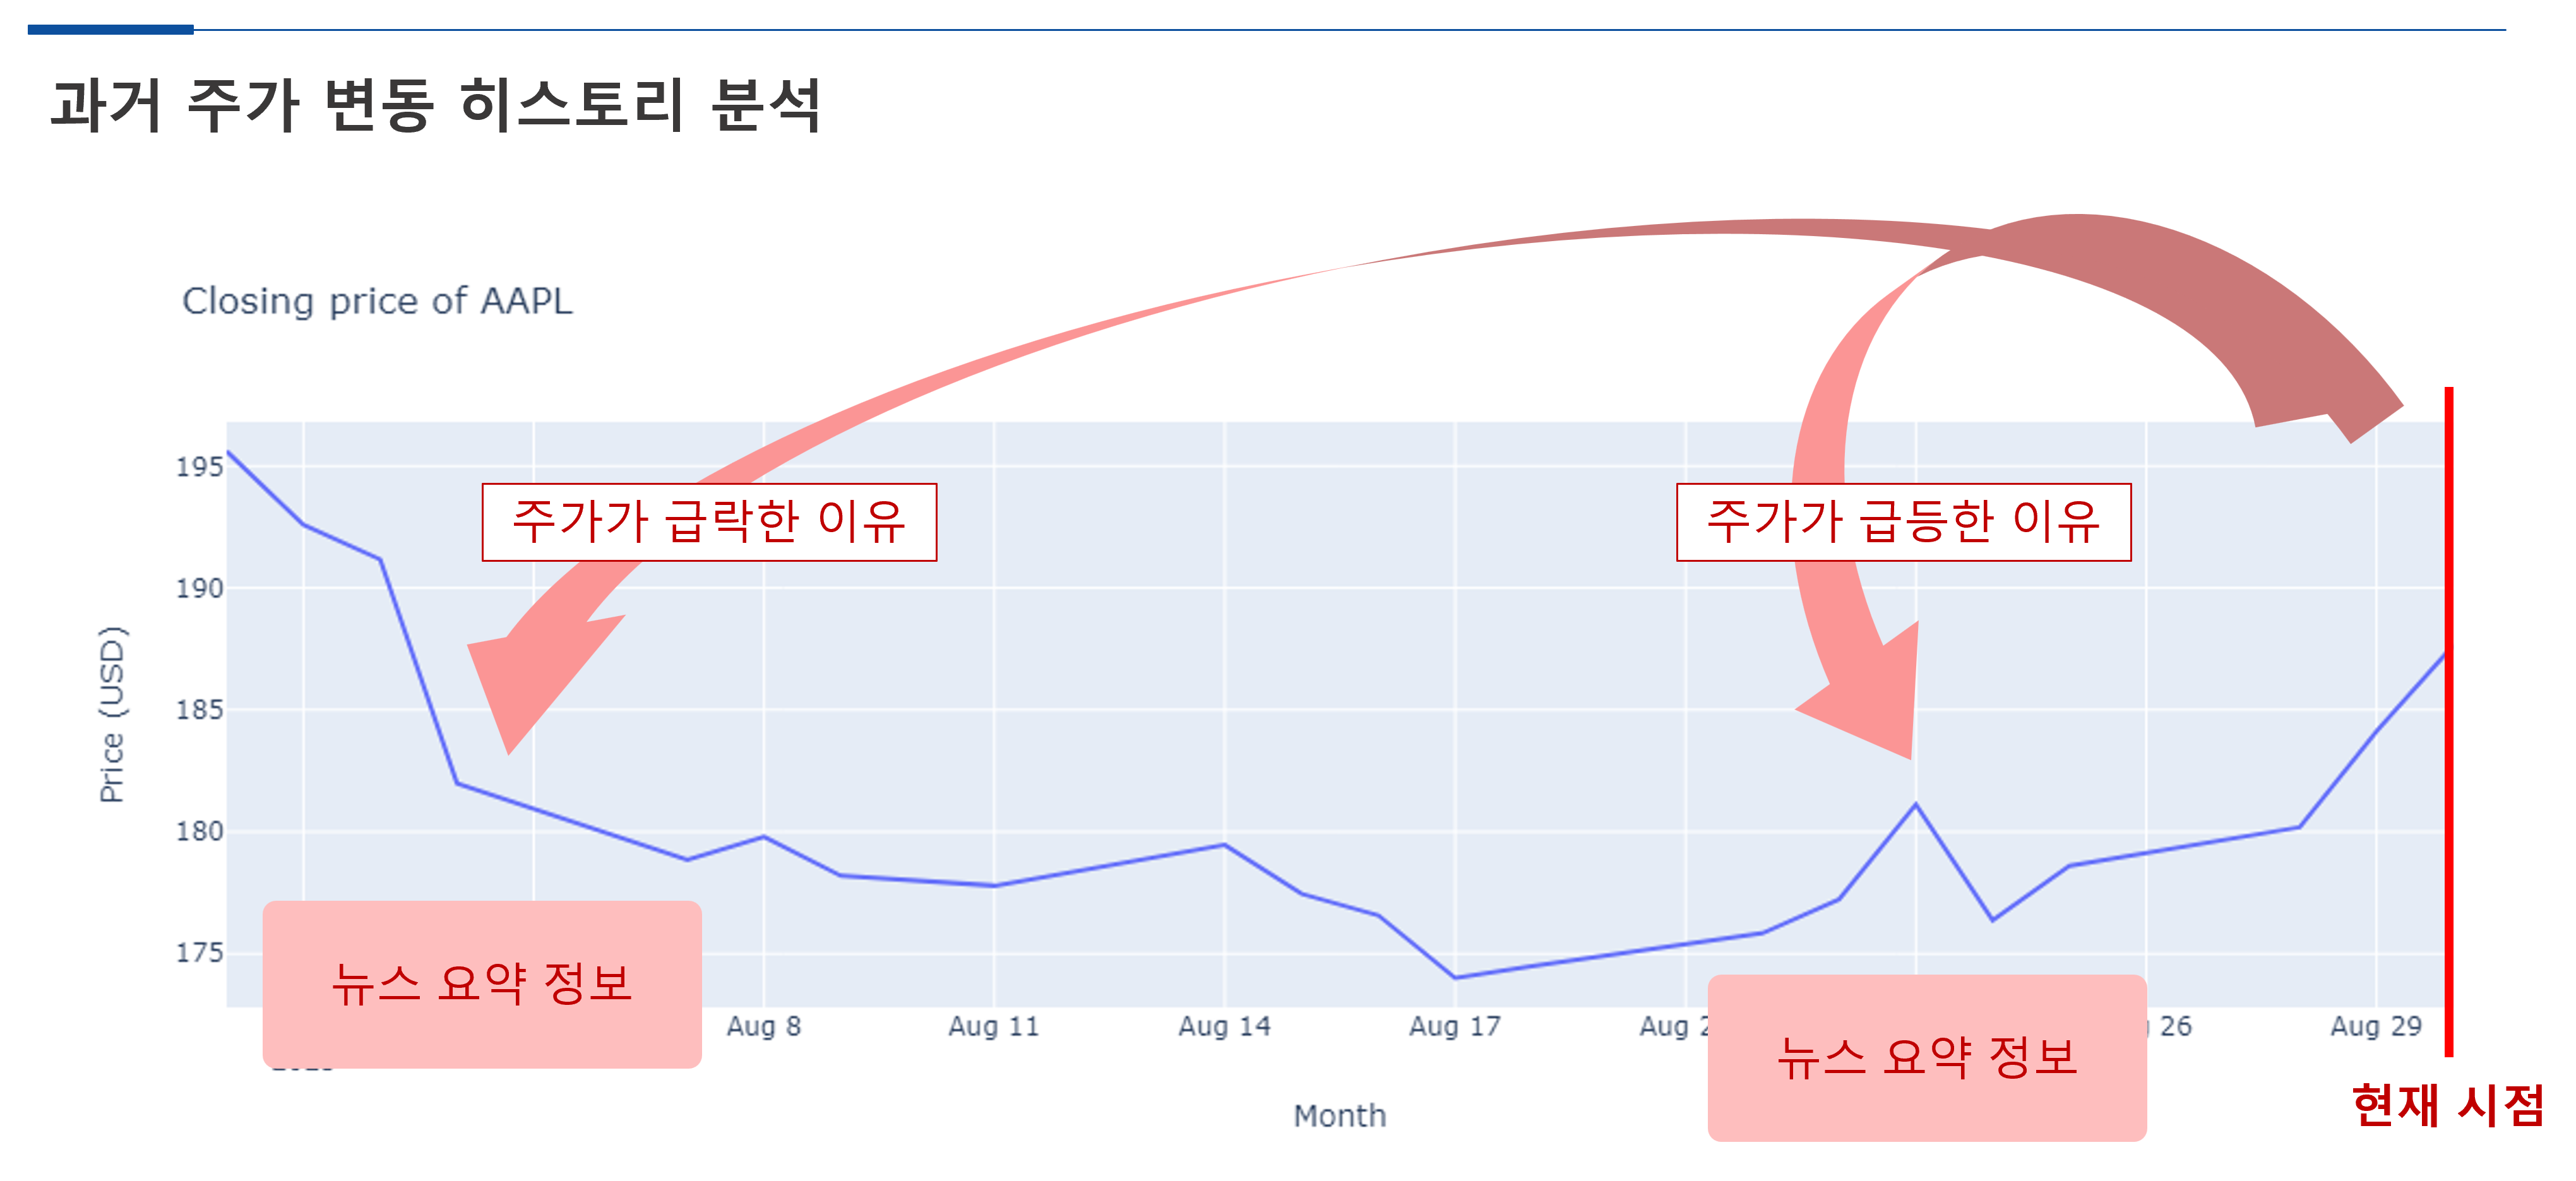

In [ ]:
tracking_data = pd.read_csv("/content/drive/MyDrive/NH대회 공유문서함/data_files/tracking_data.csv")
news_data = pd.read_csv("/content/drive/MyDrive/NH대회 공유문서함/data_files/NASDAQ_RSS_word+finbert_analysis.csv")

In [ ]:
rgs_dt = []

for i in news_data['rgs_dt'] :
    rgs_dt.append(int(i.replace('-', '')))

news_data['rgs_dt'] = rgs_dt

- **INPUT**: 1) 종목코드 2) 기준 날짜 3) 백트래킹 기간 <- 사용자가 직접 입력
- **OUTPUT**: 1) 기사 요약문 2) 기사 url링크


In [ ]:
def tck_backtracking(tracking_data, news_data, search_tck, search_date, tracking_period) :
    selected_trakcing = tracking_data[(tracking_data['tck_iem_cd'] == search_tck) & (tracking_data['trd_dt'] <= search_date)]
    if selected_trakcing['pred'].iloc[0] == 1 :
        selected_news = news_data[(news_data['tck_iem_cd'] == search_tck) & (news_data['rgs_dt'] <= search_date) & ((search_date - tracking_period) <= news_data['rgs_dt']) & (news_data['dic_sentiment'] == 0) & (news_data['fin_sentiment'] == 0)]
        if len(selected_news) == 0 :
            print('뉴스 정보가 없어요')
        else :
            print("왜 올랐을까? 아래 기사를 확인해보세요.")
            selected_df = news_data.loc[selected_news.index.to_list()]
            selected_df['dic_prob+fin_positive_prob'] = selected_df['dic_prob'] + selected_df['fin_positive_prob']
            sorted_df = selected_df.sort_values(by='dic_prob+fin_positive_prob', ascending=False)
            for i in sorted_df.index.to_list() :
                print(news_data['news_smy_ifo'].loc[i])
                print(news_data['url_ifo'].loc[i])
                print('--------' * 20)

    else :
        selected_news = news_data[(news_data['tck_iem_cd'] == search_tck) & (news_data['rgs_dt'] <= search_date) & ((search_date - tracking_period) <= news_data['rgs_dt']) & (news_data['dic_sentiment'] == 0) & (news_data['fin_sentiment'] == 0)]
        if len(selected_news) == 0 :
            print('뉴스 정보가 없어요')
        else :
            print("왜 떨어졌을까? 아래 기사를 확인해보세요.")
            selected_df = news_data.loc[selected_news.index.to_list()]
            selected_df['neg_dic_prob'] = 1 - selected_df['dic_prob']
            selected_df['neg_dic_prob+fin_negative_prob'] = selected_df['neg_dic_prob'] + selected_df['fin_negative_prob']
            sorted_df = selected_df.sort_values(by='neg_dic_prob+fin_negative_prob', ascending=False)
            for i in selected_news.index.to_list() :
                print(news_data['news_smy_ifo'].loc[i])
                print(news_data['url_ifo'].loc[i])
                print('--------' * 20)


In [ ]:
tck_backtracking(tracking_data, news_data, 'AAPL', 20230820, 10) #사용자가 직접 입력

왜 떨어졌을까? 아래 기사를 확인해보세요.
"South Korean tech giant Naver's webcomics business, called ""Webtoon"", will rely on its deep bank of content and creators to fend off new competition from larger Silicon Valley rivals, its CEO said, as it plans a listing next year."
https://www.nasdaq.com/articles/navers-webtoon-ceo-says-barrier-for-new-entrants-is-high-0
----------------------------------------------------------------------------------------------------------------------------------------------------------------
"South Korean tech giant Naver's webcomics business, called ""Webtoon"", will rely on its deep bank of content and creators to fend off new competition from larger Silicon Valley rivals, its CEO said, as it plans a listing next year."
https://www.nasdaq.com/articles/navers-webtoon-ceo-says-barrier-for-new-entrants-is-high
----------------------------------------------------------------------------------------------------------------------------------------------------------------
Earn

<font color = "#CC3D3D"><p>
# **END**